# Creating XGBoost model for predicting closing stock price based on the news for the day as well as the company's ESG rating

# Mount Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import the necessary libraries


In [ ]:
import pandas as pd

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load the data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/vnp-project/data/data_with_esg.csv")

Sort the data based on company name and the date

In [ ]:
data = data.sort_values(by=['company', 'Date'])

Upon further review, we discovered that the data for 'Samsung' is denominated in a different currency compared to the other companies. To ensure consistency in the analysis, we decided to omit Samsung's data.

In [ ]:
data = data[~data['company'].str.contains('Samsung')]

Creating new features regarding stock prices (Open, High, Low, Close, Adj Close and Volume) from the previous data entry for each one of the companies.
- The 30-day rolling standard deviation (volatility) of the 'Close' price
   is calculated using a rolling window of 30 days. This captures the historical variability of the
   stock price.
- The percentage change in the 'Close' price from one day to the next is
   calculated as the daily return. This helps capture price movements.

In [ ]:
data['previous_Open'] = data.groupby('company')['Open'].shift(1)
data['previous_High'] = data.groupby('company')['High'].shift(1)
data['previous_Low'] = data.groupby('company')['Low'].shift(1)
data['previous_Close'] = data.groupby('company')['Close'].shift(1)
data['previous_Adj Close'] = data.groupby('company')['Adj Close'].shift(1)
data['previous_Volume'] = data.groupby('company')['Volume'].shift(1)
data['Volatility'] = data['Close'].rolling(window=30).std()
data['Returns'] = data['Close'].pct_change()
data['previous_volatility'] = data.groupby('company')['Volatility'].shift(1)
data['previous_returns'] = data.groupby('company')['Returns'].shift(1)

This section of the code generates TF-IDF (Term Frequency-Inverse Document Frequency) features from the
'Title' column of the dataset. TF-IDF is used to quantify the importance of words in a text document based
on their frequency in a document and across the entire dataset.


This technique helps the model understand textual data, such as news titles, and how they may relate to the target variable.

In [ ]:
tfidf = TfidfVectorizer(max_features=100)
tfidf_features = tfidf.fit_transform(data['title']).toarray()
tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf.get_feature_names_out())
data = pd.concat([data, tfidf_df], axis=1).drop(columns=['title'])

In [ ]:
data = data.dropna()

This section of code creates a dictionary `label_mapping` that standardizes and converts text-based
labels into numerical values. The mapping is applied to multiple label columns, ensuring consistency
across different label formats (e.g., 'positive', 'POSITIVE', 'Positive' are all mapped to 1).

In [ ]:
label_mapping = {
    'negative': -1,
    'neutral': 0,
    'positive': 1,
    'NEGATIVE': -1,
    'NEUTRAL': 0,
    'POSITIVE': 1,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'social': 1,
    'environment': 2,
    'government': 3
}

In [ ]:
data['label_x'] = data['label_x'].map(label_mapping)
data['label_y'] = data['label_y'].map(label_mapping)
data['label_z'] = data['label_z'].map(label_mapping)
data['zero_shot_label'] = data['zero_shot_label'].map(label_mapping)

This section computes new coefficient columns by multiplying the mapped labels (`label_x`, `label_y`, `label_z`, `zero_shot_label`)
with their corresponding scores (`score_x`, `score_y`, `score_z`, `zero_shot_score`). The resulting coefficients represent the
weighted impact of each label.


In [ ]:
data["coef_x"] = data["label_x"] * data["score_x"]
data["coef_y"] = data["label_y"] * data["score_y"]
data["coef_z"] = data["label_z"] * data["score_z"]
data['coef_zero_shot'] = data['zero_shot_label'] * data['zero_shot_score']
data = data.drop(columns=['label_x', 'label_y', 'label_z', 'score_x', 'score_y', 'score_z', 'zero_shot_label', 'zero_shot_score'])

This section standardizes the features in the dataset to have a mean of 0 and a standard deviation of 1.
The `StandardScaler` is applied to all numerical columns while excluding non-relevant columns (e.g.,
company identifiers and dates).

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop(columns=['company', 'url', 'source', 'time', 'Date', 'ticker', 'Unnamed: 0', 'Company Name', 'Ticker', 'Unnamed: 0.1', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'previous_Close', 'previous_Adj Close', 'Volatility', 'Returns']))
data_df_scaled = pd.DataFrame(scaled_features, columns=data.columns.drop(['company', 'url', 'source', 'time', 'Date', 'ticker', 'Unnamed: 0', 'Company Name', 'Ticker', 'Unnamed: 0.1', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'previous_Close', 'previous_Adj Close', 'Volatility', 'Returns']))

This section prepares the data for training a machine learning model by splitting the dataset into features
(X) and target variable (y). The features are derived from the scaled DataFrame, while the target variable
is the 'Close' price from the original dataset.


In [ ]:
X = data_df_scaled
y = data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the model

This section initializes an XGBoost regression model using `XGBRegressor`. The model is set to optimize
for regression tasks with the objective function defined as 'reg:squarederror', which minimizes the
squared differences between predicted and actual values.

In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

This section defines a parameter grid for tuning the XGBoost model. The `param_grid` dictionary specifies
various hyperparameters and their respective values to explore during the tuning process.

Hyperparameters included:
1. `n_estimators`: Number of trees in the ensemble (100, 200).
2. `learning_rate`: Step size shrinkage to prevent overfitting (0.01, 0.1).
3. `max_depth`: Maximum depth of the trees (3, 5, 7).
4. `subsample`: Proportion of samples used for fitting the individual base learners (0.8, 1).
5. `colsample_bytree`: Proportion of features used for each tree (0.8, 1).

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

This section performs hyperparameter tuning for the XGBoost model using `GridSearchCV`. The grid search
explores the defined parameter grid to find the best combination of hyperparameters based on cross-validation.

Steps performed:
1. Initialize `GridSearchCV` with the following parameters:
   - `estimator`: The XGBoost regression model.
   - `param_grid`: The dictionary of hyperparameters to explore.
   - `cv`: Number of cross-validation folds (3).
   - `scoring`: Metric used for evaluation (negative mean squared error).
   - `verbose`: Controls the verbosity of the output (set to 1 for detailed logs).
   - `error_score`: Defines the behavior when a fit fails (set to "raise" to throw an error).

2. Fit the grid search to the training data (`X_train`, `y_train`).

In [ ]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, error_score="raise")
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, error_score='raise',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error', verbose=1)

This section extracts the best-performing XGBoost model from the results of the grid search. The
`best_estimator_` attribute of the `grid_search` object contains the model configuration with
the optimal hyperparameters identified during the tuning process.

In [ ]:
best_xgb = grid_search.best_estimator_

This section trains the best XGBoost model (`best_xgb`) on the training dataset. The `fit` method
is called with the training features (`X_train`) and target variable (`y_train`), allowing the
model to learn the underlying patterns in the data.

In [ ]:
best_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

1. **Mean Squared Error (MSE): 71.29**
   - A low MSE indicates that the model predictions are quite close to the actual values. While some error exists, the value is small relative to the range of stock prices, suggesting high accuracy.

2. **R-squared (R²): 0.9984**
   - An R-squared value of 0.9984 indicates that 99.84% of the variance in the target variable (stock Close price) is explained by the model. This suggests an extremely good fit, meaning the model is highly effective in capturing the relationships within the data.

While the results indicate excellent performance (low MSE and high R-squared), it is crucial to consider the possibility of overfitting, where the model learns the training data too well, including noise and outliers, resulting in poor generalization to unseen data.


In [ ]:
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 71.28573952686102
R-squared: 0.9984279316394087


In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.9 MB/s eta 0:00:00


# Evaluating the model

In [ ]:
import shap

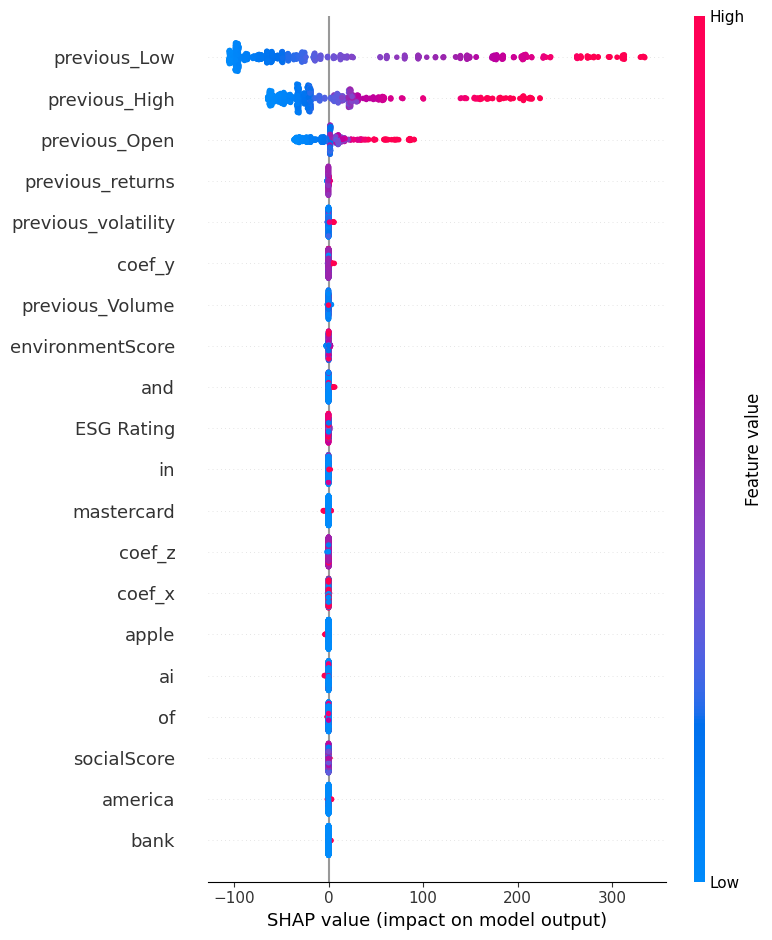

In [ ]:
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

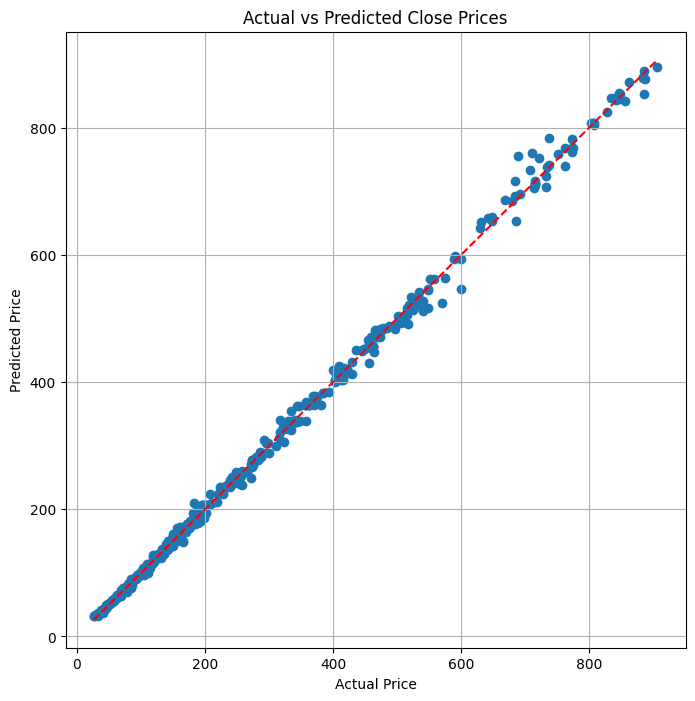

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()

# Saving the model

In [ ]:
best_xgb.save_model('/content/drive/MyDrive/vnp-project/models/xgb_stock_model1.json')

# Creating a new model

Because of the concerns of overfitting, we decided to create a new model, excluding the features from the stock data for the previous day.


In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop(columns=['company', 'url', 'source', 'time', 'Date', 'ticker', 'Unnamed: 0', 'Company Name', 'Ticker', 'Unnamed: 0.1', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'previous_Close', 'previous_Adj Close', 'previous_High', 'previous_Low', 'previous_Volume', 'previous_Open']))
data_df_scaled = pd.DataFrame(scaled_features, columns=data.columns.drop(['company', 'url', 'source', 'time', 'Date', 'ticker', 'Unnamed: 0', 'Company Name', 'Ticker', 'Unnamed: 0.1', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'previous_Close', 'previous_Adj Close', 'previous_High', 'previous_Low', 'previous_Volume', 'previous_Open']))

In [ ]:
X = data_df_scaled
y = data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

In [ ]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, error_score="raise")
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, error_score='raise',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

1. **Mean Squared Error (MSE): 603.12**
   - This MSE is significantly higher than the previous value of 71.29, indicating that the model's predictions are, on average, further from the actual stock prices. This increase in error suggests a decline in predictive accuracy.

2. **R-squared (R²): 0.9867**
   - While still high, this R-squared value is lower than the previous 0.9984. This indicates that approximately 98.67% of the variance in the target variable is explained by the model, which, while still strong, shows a reduction in explanatory power compared to the earlier model.

Comparison to Previous Results:
- The increase in MSE and decrease in R-squared suggest that the model may have lost some of its ability to generalize effectively compared to the earlier version.
- The drop in performance could indicate potential overfitting or a change in the underlying data distribution, necessitating further investigation.

In [ ]:
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 603.1208083446111
R-squared: 0.9866993434211961


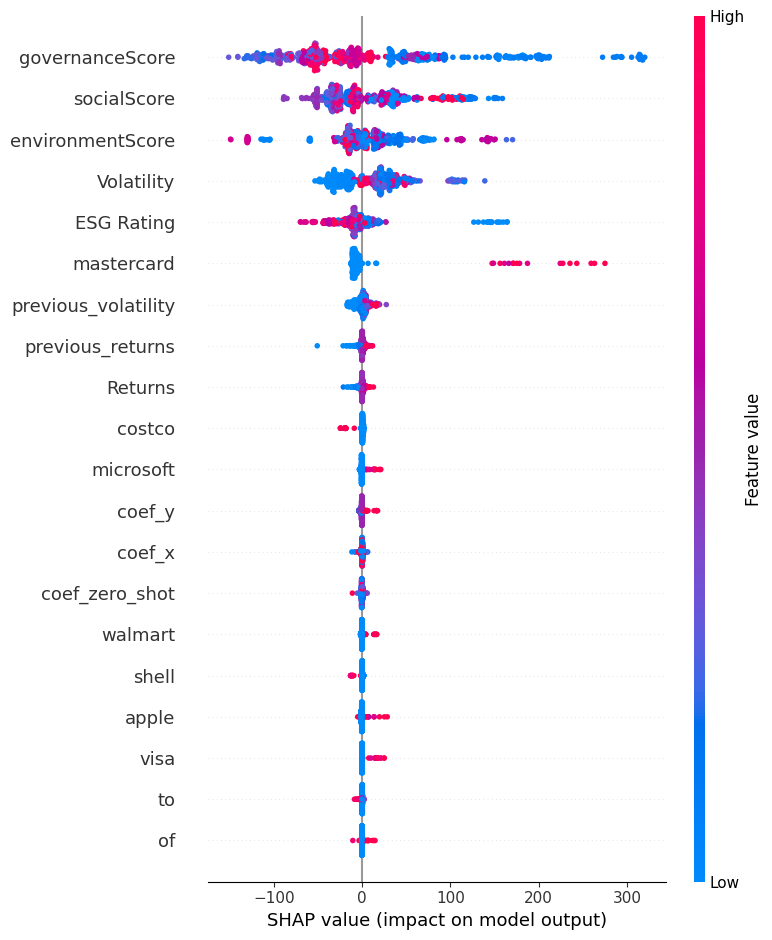

In [ ]:
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

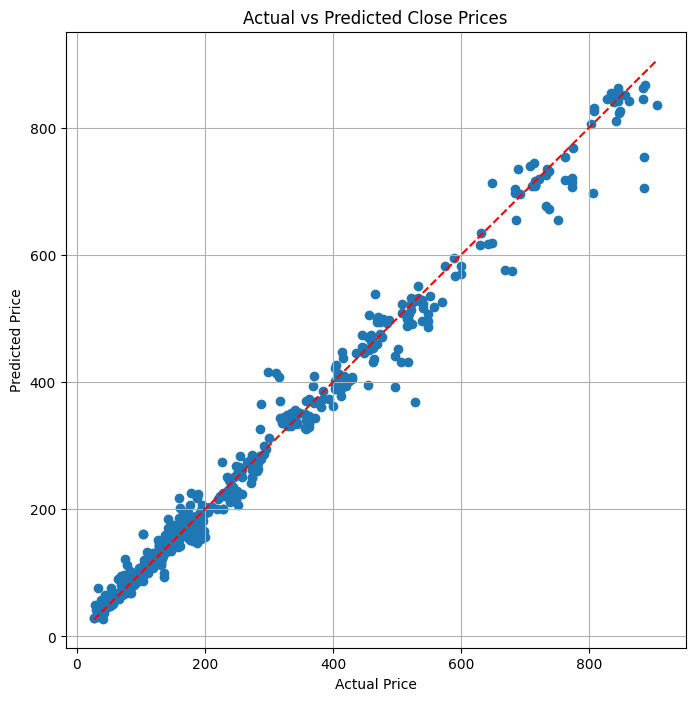

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()

In [ ]:
best_xgb.save_model('/content/drive/MyDrive/vnp-project/models/xgb_stock_model2.json')

# Conclusion

Based on the evaluation of both models on different data features, we conclude that the dataset may be overly detailed and contain too many features for effectively predicting the closing stock price. This complexity can lead to overfitting, where the model learns noise rather than meaningful patterns in the data.

A simpler dataset, with fewer but more relevant features, might enhance the model's ability to generalize to unseen data. Streamlining the feature set could also improve computational efficiency and interpretability of the model's predictions.

Future work should focus on feature selection techniques to identify the most impactful variables, along with experimenting with different modeling approaches that prioritize generalization over fitting to the training data. Ultimately, refining the dataset and model could lead to more robust predictions and improved performance in real-world applications.